pit stops constructors 2011-2020
milestones decision tree
-clockwise - anticlockwise-


In [23]:
#import libraries
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import DBSCAN
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta
from statistics import mean

np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

In [24]:
#read the data
f1_db = {}
for file_name in glob.glob('*.csv'):
    f1_db[file_name.split(".")[0]] = pd.read_csv(file_name)

In [25]:
# Pre-processing steps here

del f1_db["seasons"]

general_info = {}
extract = ["circuits", "constructors", "drivers", "status"]
for ext in extract:
    general_info[ext] = f1_db[ext]
    del f1_db[ext]

f1_db["races"].drop(f1_db["races"][f1_db["races"]['year'] == 2021].index, inplace = True)

In [26]:
def filt_year(f1_db, year):
    
    raceIds = f1_db["races"][f1_db["races"]['year'] == year]["raceId"].tolist()
    
    year_data = {}
    for key, value in f1_db.items():
        year_data[key] = value[value["raceId"].isin(raceIds)]
        
    return year_data

f1_per_year = {}
for year in range(1950,2021):
    f1_per_year[year] = filt_year(f1_db, year)

In [27]:
general_info["drivers"]["name"] = general_info["drivers"]["forename"] + ' ' + general_info["drivers"]["surname"]
general_info["status"].rename(columns={'status':'name'}, inplace=True)

def naming(Id, to_name): #to_name = circuits / constructors / drivers / status
    return general_info[to_name][general_info[to_name][(lambda x: x if x[-2] == 'u' else x[:-1])(to_name) + "Id"] == Id]["name"].values[0]

In [28]:
drivers_active = {}
for driverId in general_info["drivers"]["driverId"]:
    years_active = []
    for year in range(1950, 2021):
        if driverId in f1_per_year[year]["driver_standings"]["driverId"].values:
            years_active.append(year)
    drivers_active[driverId] = years_active

In [29]:
lap_evol = np.zeros((71, 77))

for year in range(1950,2021):
    for raceId in f1_per_year[year]["races"]["raceId"].unique():
        cId = f1_per_year[year]["races"].loc[f1_per_year[year]["races"]["raceId"] == raceId, "circuitId"].values[0]
        ts = f1_per_year[year]["qualifying"][f1_per_year[year]["qualifying"]["raceId"] == raceId]["q3" if year > 2005 else "q1"]
        if not len(ts): continue
        t = min(ts, key = lambda x: datetime(2020,1,1) if isinstance(x,float) or x=='\\N' else datetime.strptime(x, "%M:%S.%f"))
        if t == '\\N' or isinstance(t, float): continue
        lap_evol[year - 1950][cId - 1] = (datetime.strptime(t, "%M:%S.%f") - datetime(1900, 1, 1)).total_seconds()

In [30]:
lap_evol = lap_evol[44:]

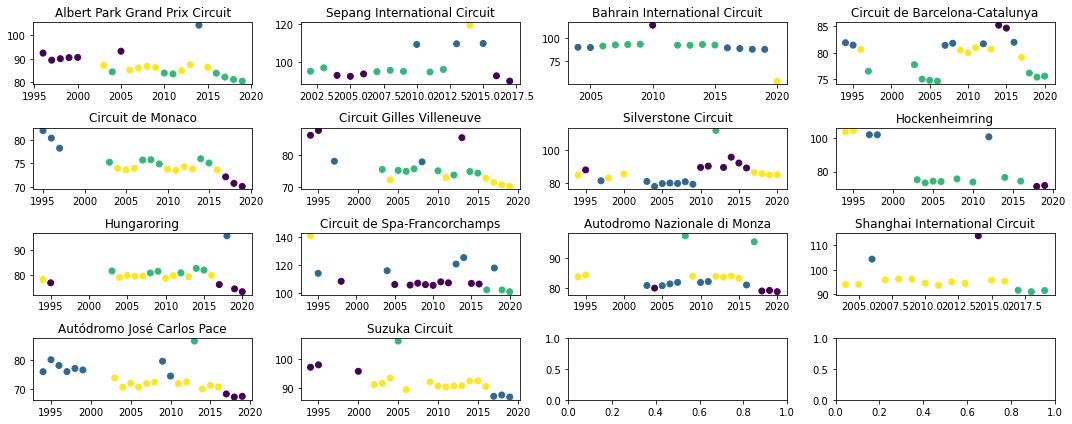

In [31]:
fig, axs = plt.subplots(4,4, figsize=(15, 6))
axs = axs.ravel()
i=0
for cid in range(77):
    track = lap_evol[:,cid]
    if len(track[track!=0]) < 13: continue
    centroids, avg_distance = kmeans(track[track!=0], 4)
    groups, cdist = vq(track[track!=0], centroids)
    axs[i].scatter(np.arange(2021-len(track),2021)[track!=0], track[track!=0], c=groups)
    axs[i].set_title(naming(cid+1, "circuits"))
    i+=1
plt.tight_layout()

plt.savefig('1D_clustering.jpg')

In [32]:
def p2D(a, mul=1):
    return np.vstack((a, mul*np.arange(len(a)))).T

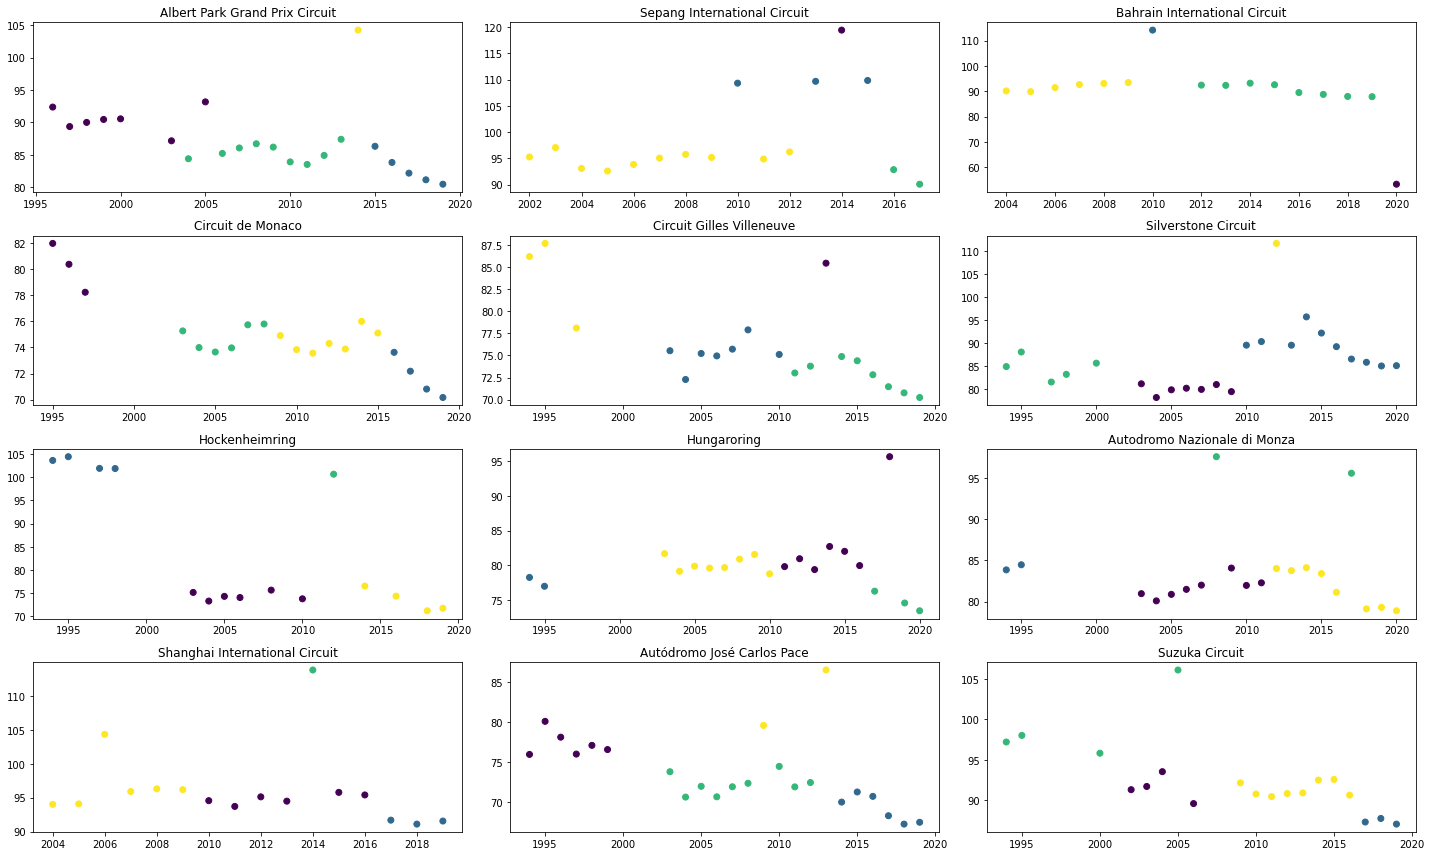

In [33]:
fig, axs = plt.subplots(4,3, figsize=(20, 12))
axs = axs.ravel()
i=0
breaks = np.zeros(len(lap_evol), dtype=int)
l = []
for cid in range(76):
    if i == 12: break
    track = lap_evol[:,cid]
    if len(track[track!=0]) < 13 or "Spa" in naming(cid+1, "circuits") or "Barcelona" in naming(cid+1, "circuits"):
        continue
    centroids, avg_distance = kmeans(p2D(track)[track!=0], 4)
    groups, cdist = vq(p2D(track)[track!=0], centroids)
    axs[i].scatter(np.arange(2021-len(track),2021)[track!=0], track[track!=0], c=groups)
    axs[i].set_title(naming(cid+1, "circuits"))
    i+=1
    aug_g = np.full(len(track)+2, -1)
    j = 0
    for k, t in enumerate(track):
        if not t: continue
        aug_g[k+1] = groups[j]
        j += 1
    for k in range(len(aug_g)):
        if aug_g[k] == -1: continue
        if aug_g[k] != aug_g[k-1] and aug_g[k] != aug_g[k+1] and aug_g[k-1] != -1:
            l.append(naming(cid+1, "circuits")+" "+str(k+1993)+" rainy quali(?)")
            aug_g[k] = aug_g[k-1]
        if aug_g[k] != aug_g[k+1] and aug_g[k+1] != -1: breaks[k-1] += 1
plt.tight_layout()
plt.savefig('2D_clustering.jpg')

In [34]:
for li in l: print(li)

Albert Park Grand Prix Circuit 2004 rainy quali(?)
Albert Park Grand Prix Circuit 2014 rainy quali(?)
Sepang International Circuit 2010 rainy quali(?)
Sepang International Circuit 2013 rainy quali(?)
Sepang International Circuit 2014 rainy quali(?)
Sepang International Circuit 2015 rainy quali(?)
Bahrain International Circuit 2010 rainy quali(?)
Bahrain International Circuit 2020 rainy quali(?)
Circuit Gilles Villeneuve 2013 rainy quali(?)
Silverstone Circuit 2012 rainy quali(?)
Hungaroring 2017 rainy quali(?)
Autodromo Nazionale di Monza 2008 rainy quali(?)
Autodromo Nazionale di Monza 2017 rainy quali(?)
Shanghai International Circuit 2014 rainy quali(?)
Autódromo José Carlos Pace 2009 rainy quali(?)
Autódromo José Carlos Pace 2013 rainy quali(?)
Suzuka Circuit 2005 rainy quali(?)


In [35]:
for i, b in enumerate(breaks):
    print(i+1994, b)

1994 0
1995 0
1996 0
1997 0
1998 0
1999 0
2000 0
2001 0
2002 0
2003 1
2004 1
2005 1
2006 0
2007 1
2008 2
2009 4
2010 2
2011 2
2012 3
2013 4
2014 2
2015 2
2016 4
2017 0
2018 1
2019 1
2020 0


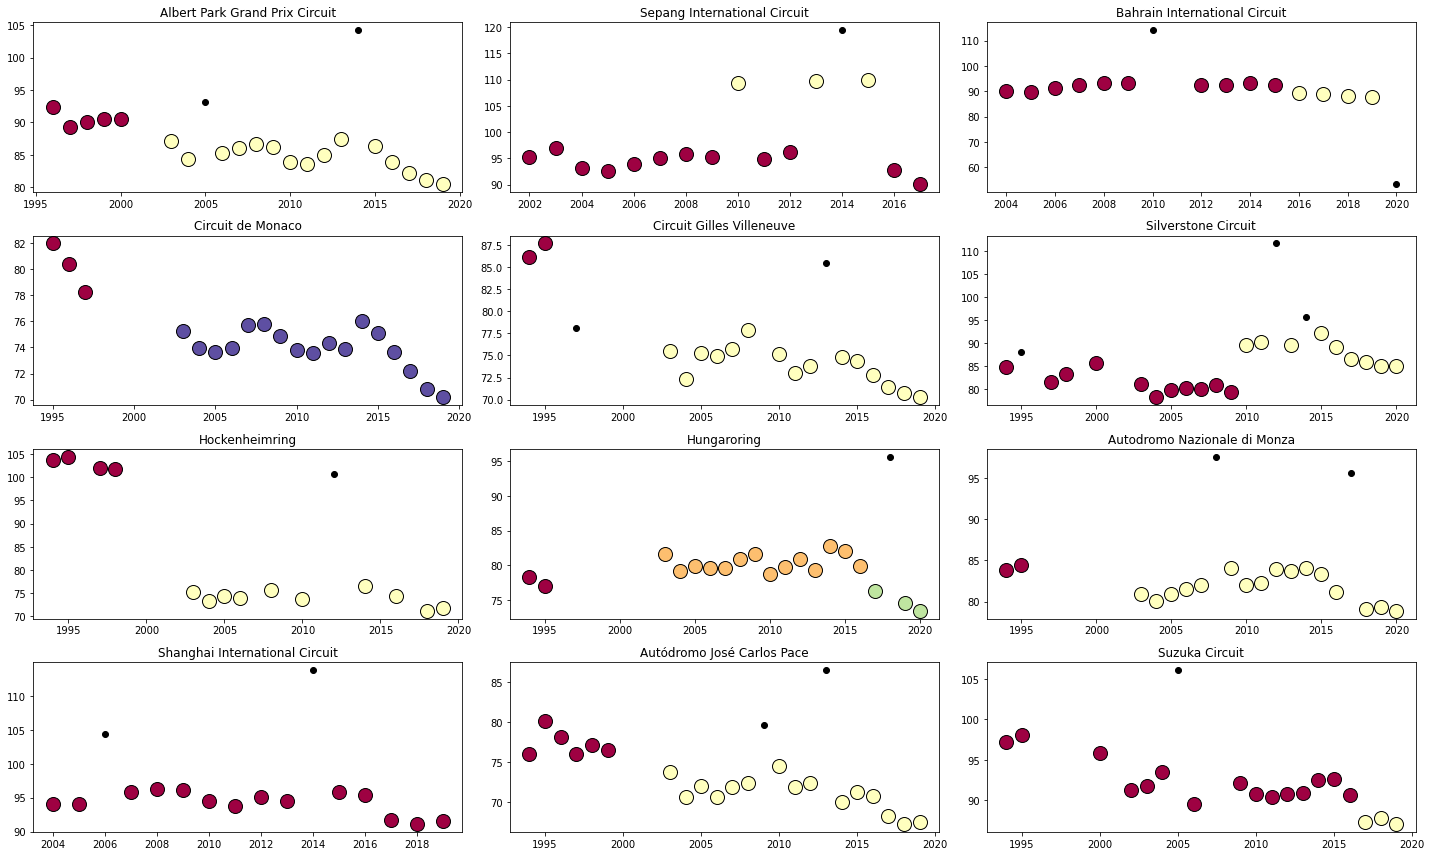

In [36]:
#fig, axs = plt.subplots(5,3, figsize=(20, 12))
#axs = axs.ravel()
#i=0
mul = 0.3
fig, axs = plt.subplots(4,3, figsize=(20, 12))
axs = axs.ravel()
i=0
for cid in range(76):
    if i == 12: break
    track = lap_evol[:,cid]
    if (len(track[track!=0]) < 13 or ("Spa" in naming(cid + 1, "circuits")) or ("Barcelona" in naming(cid + 1, "circuits"))): continue
    X = p2D(track, mul=mul)[track!=0]
    db = DBSCAN(eps=2.81, min_samples=2).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
        # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        
        xy = X[class_member_mask & core_samples_mask]
        axs[i].plot(2021-len(track)+1/mul*xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
        xy = X[class_member_mask & ~core_samples_mask]
        axs[i].plot(2021-len(track)+1/mul*xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    axs[i].set_title(naming(cid+1, "circuits"))
    i += 1
plt.tight_layout()
plt.savefig('DBScan_rains.jpg')

    #axs[i].scatter(np.arange(2021-len(track),2021)[track!=0], track[track!=0], c=groups)
    #axs[i].set_title(naming(cid+1, "circuits"))
    #i+=1
#plt.tight_layout()

In [112]:
def disparity(year, driver1, driver2):
    rl = []
    ql = []
    for raceId in f1_per_year[year]["races"]["raceId"].unique():
        r = f1_per_year[year]["results"]
        q = f1_per_year[year]["qualifying"]
        try:
            res1 = r.loc[(r['driverId'] == driver1) & (r['raceId'] == raceId)]
            res1 = res1['position'].values[0]
            res2 = r.loc[(r['driverId'] == driver2) & (r['raceId'] == raceId)]
            res2 = res2['position'].values[0]
            rl.append(int(res1) - int(res2))
        except:
            continue
        try:
            qual1 = q.loc[(q['driverId'] == driver1) & (q['raceId'] == raceId)]
            qual1 = qual1['position'].values[0]
            qual2 = q.loc[(q['driverId'] == driver2) & (q['raceId'] == raceId)]
            qual2 = qual2['position'].values[0]
            ql.append(int(qual1) - int(qual2))
        except:
            continue
    return rl, ql
        
        


teams = {}
for year in range(2011,2021):
    team_disp = {}
    # constr = f1_per_year[year]['constructor_standings']['constructorId'].unique()
    x = f1_per_year[year]['constructor_standings']
    constr = x[x.raceId == x.raceId.max()].sort_values("points", ascending = False)
    for cons in constr['constructorId']:
        x = f1_per_year[year]['results']
        drivers = x['driverId'][x['constructorId'] == cons].unique()
        if len(drivers) < 2: continue
        driver_1 = drivers[0]
        driver_2 = drivers[1]
        if (year == 2015 and cons == 1): driver_2 = 4 #print(naming(driver_1, "drivers"), naming(4, "drivers"))
        if (year == 2017 and naming(cons, "constructors") == "Sauber"): driver_1 = drivers[2]
        if (year == 2016 and naming(cons, "constructors") == "Red Bull"): driver_2 = drivers[2]
        if (year == 2016 and naming(cons, "constructors") == "Toro Rosso"): driver_2 = drivers[2]
        rl, ql = disparity(year, driver_1, driver_2)
        team_disp[cons] = (rl, ql)
    teams[year] = team_disp

In [113]:
mycolors = {9:   '#1E41FF',
            1:   '#FF8700',
            6:   '#DC0000',
            131: '#00D2BE',
            4:   '#FFF500',
            10:  '#FF80C7',
            15:  '#006EFF',
            5:   '#469BFF',
            3:   '#86F6F9',
            205: '#004225',
            166: 'black',
            164: 'grey',
            208: '#FFB800',
            206: '#323232',
            207: '#004225',
            209: '#323232',
            210: '#F0D787',
            211: '#F596C8',
            51:  '#9B0000',
            213: '#C8C8C8'
           }

In [114]:
def rsz(i, arr):
    y = np.unique(arr)
    x = np.full(len(y), i+1)
    s = 10*np.bincount(np.array(arr)+21)
    return x, y, s[s!=0]
def plotter(t): 
    for y in range(2011, 2021, 2):
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        axs = ax.ravel()
        for year in range(y, y+2):
            data = []
            for i, (k, v) in enumerate(teams[year].items()):
                s = 1 if (np.mean(v[t]) >= 0) else -1
                data.append(s*np.array(v[t]))
                #[i+1]*len(v[t]), s*np.array(v[t]), color=mycolors[k], s=rsz(k)
                xs, ys, sz = rsz(i, s*np.array(v[t]))
                axs[year - y].scatter(xs, ys, color=mycolors[k], s=sz)
                axs[year - y].set_title("{} Formula One World Championship {}".format(year, 'Races' if t==0 else 'Qualifying'))
            axs[year - y].boxplot(data)
            axs[year - y].set_xticks(range(1, len(teams[year]) + 1))
            axs[year - y].set_xticklabels([naming(k, "constructors") for k in teams[year]])
            axs[year - y].set_ylim(-20, 20)
        plt.tight_layout()
        plt.savefig('teammate disparity {} - {} {}.jpg'.format(year - 1, year, 'races' if t==0 else 'qualifying'))

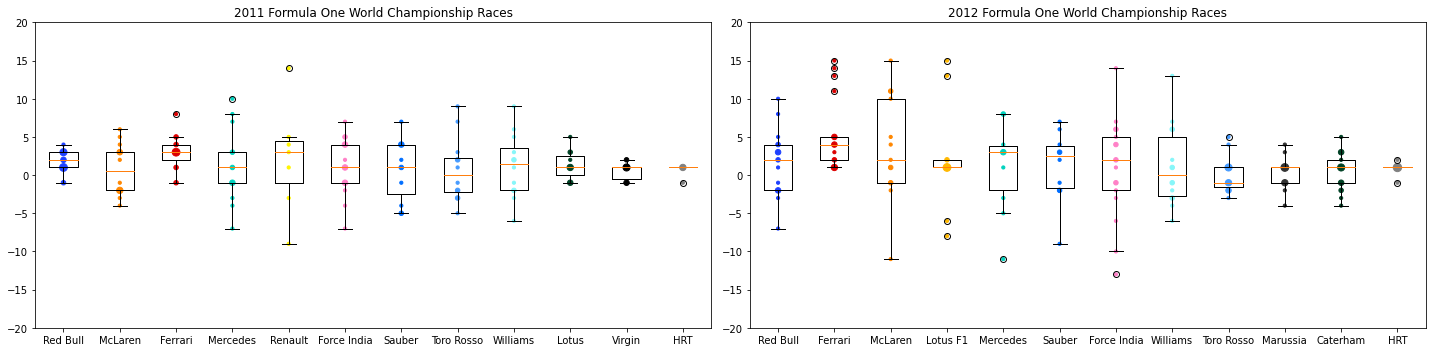

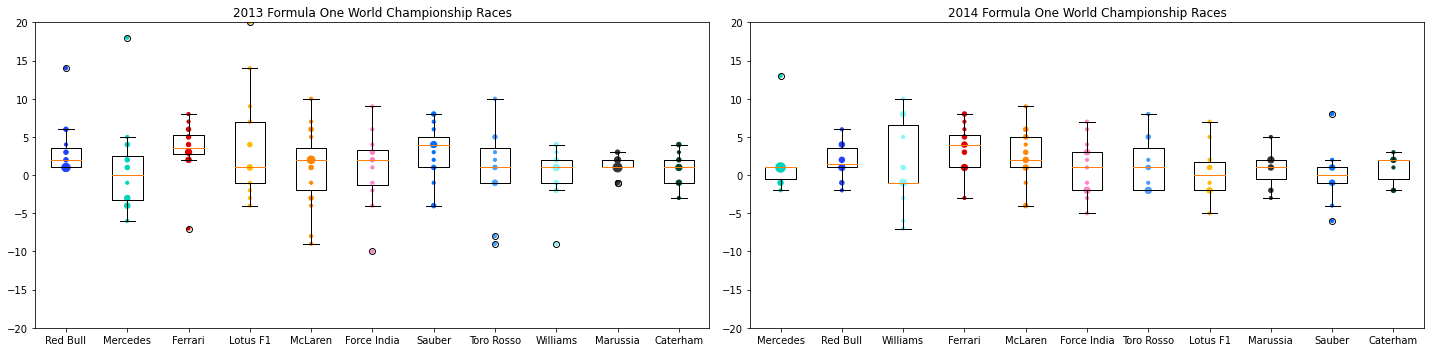

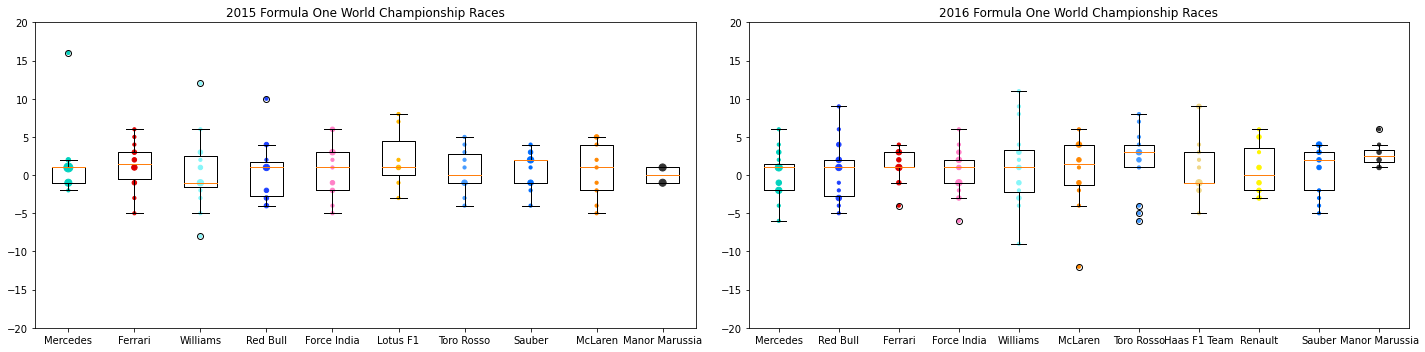

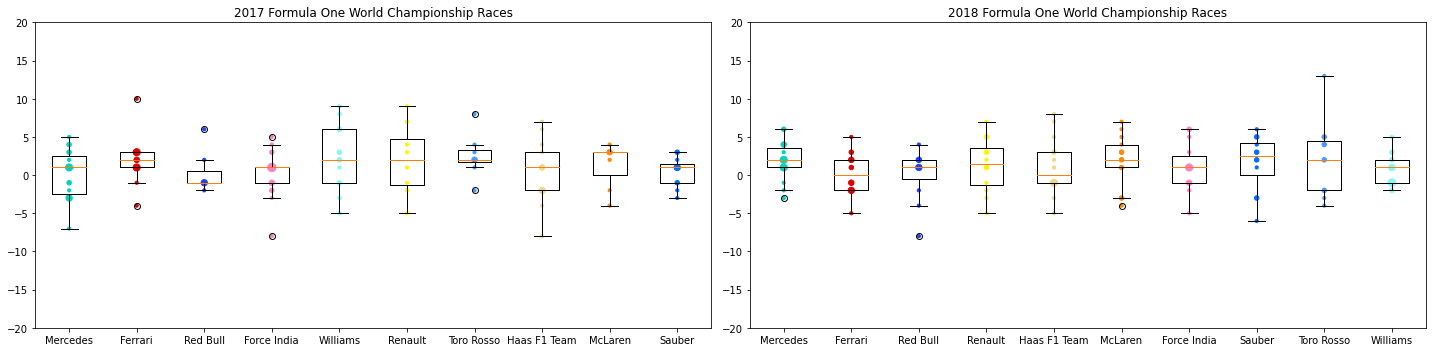

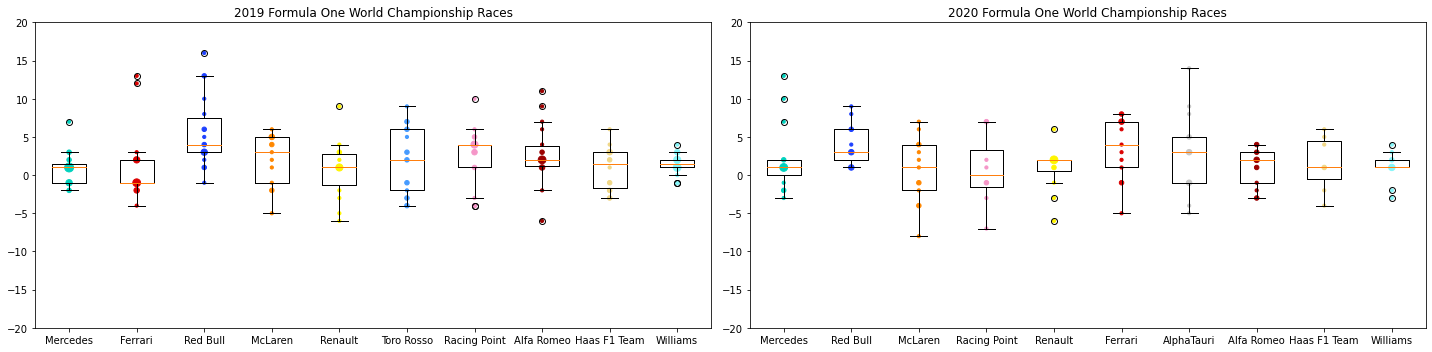

In [115]:
plotter(0)

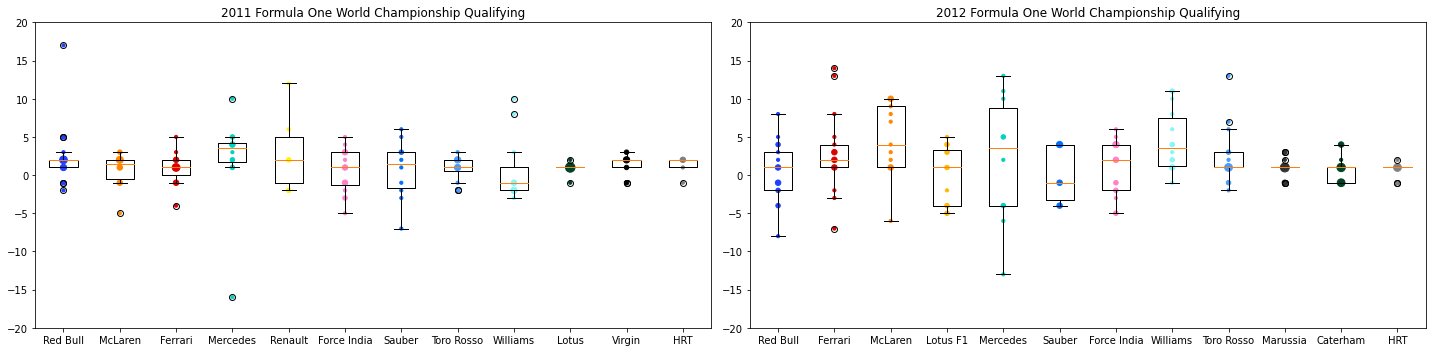

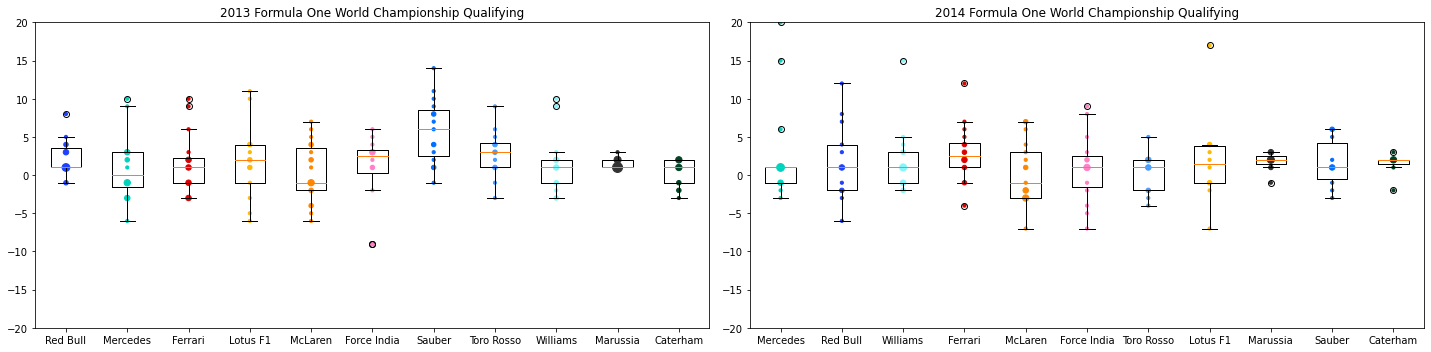

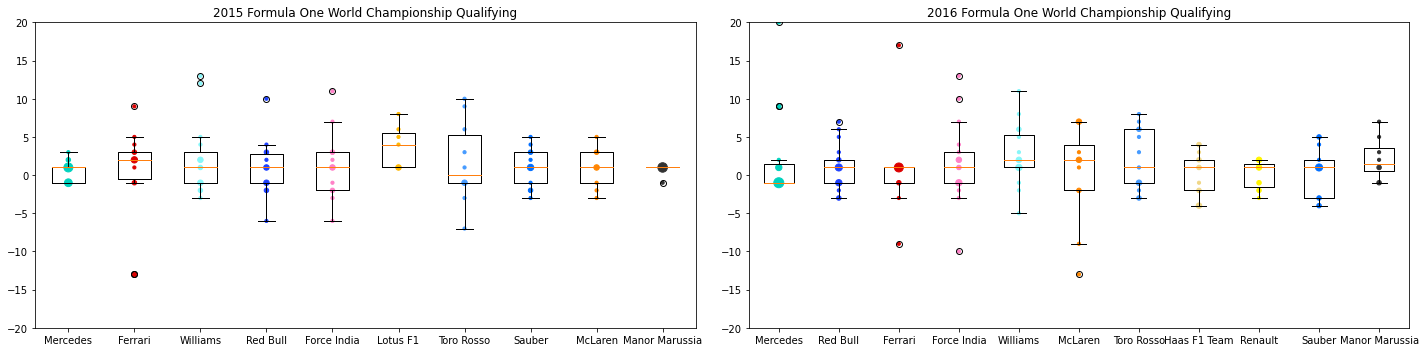

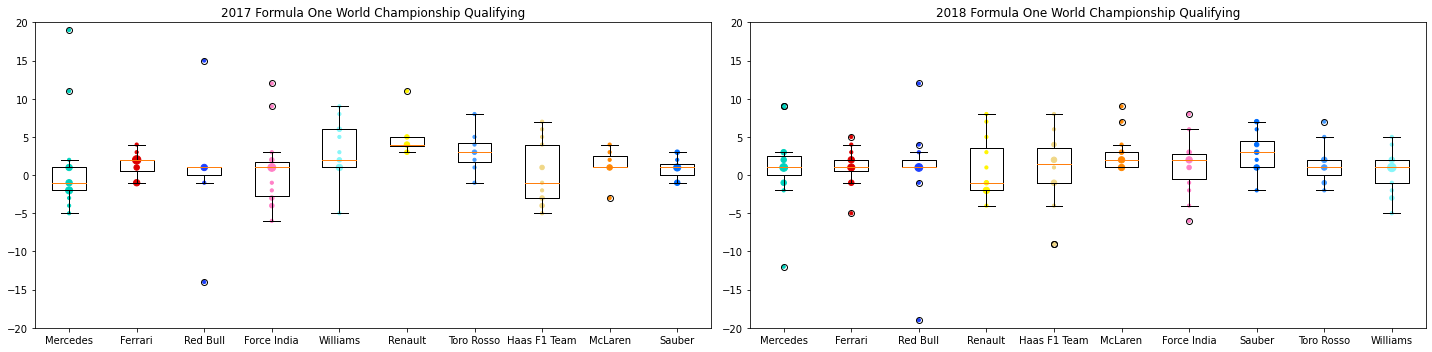

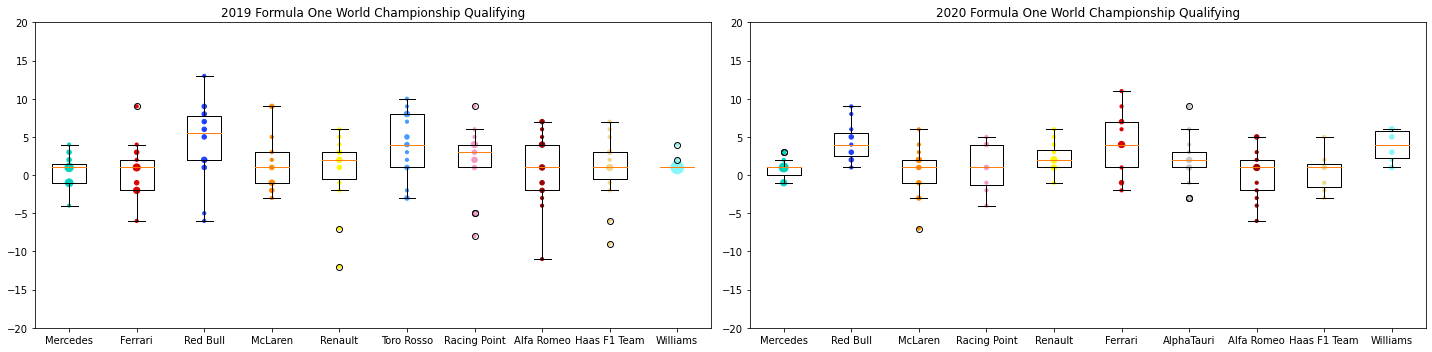

In [116]:
plotter(1)

In [45]:
def mean_pit(year, drivers):
    q = []
    for raceId in f1_per_year[year]["races"]["raceId"].unique():
        p = []
        x = f1_per_year[year]["pit_stops"]
        for driver in drivers:
            x1 = x.loc[(x['driverId'] == driver) & (x['raceId'] == raceId)]["milliseconds"].values.tolist()
            p += [x for x in x1 if x < 100000]
        if p == []: continue
        q.append(mean(p))
    return 0 if q == [] else mean(q)

pitstops = {}
for year in range(2011,2021):
    cons_pit = {}
    constr = f1_per_year[year]['constructor_results']['constructorId'].unique()
    for cons in constr:
        x = f1_per_year[year]['results']
        drivers = x['driverId'][x['constructorId'] == cons].unique()
        cons_pit[naming(cons, "constructors")] = mean_pit(year, drivers)
    pitstops[year] = cons_pit

In [46]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

Coefficients: 
 [[0.28399291]]
Coefficients: 
 [[0.23924714]]
Coefficients: 
 [[0.1970592]]
Coefficients: 
 [[0.13597049]]
Coefficients: 
 [[0.2723711]]
Coefficients: 
 [[0.18364506]]
Coefficients: 
 [[0.19387276]]
Coefficients: 
 [[0.09858946]]
Coefficients: 
 [[0.07380232]]
Coefficients: 
 [[0.15014729]]


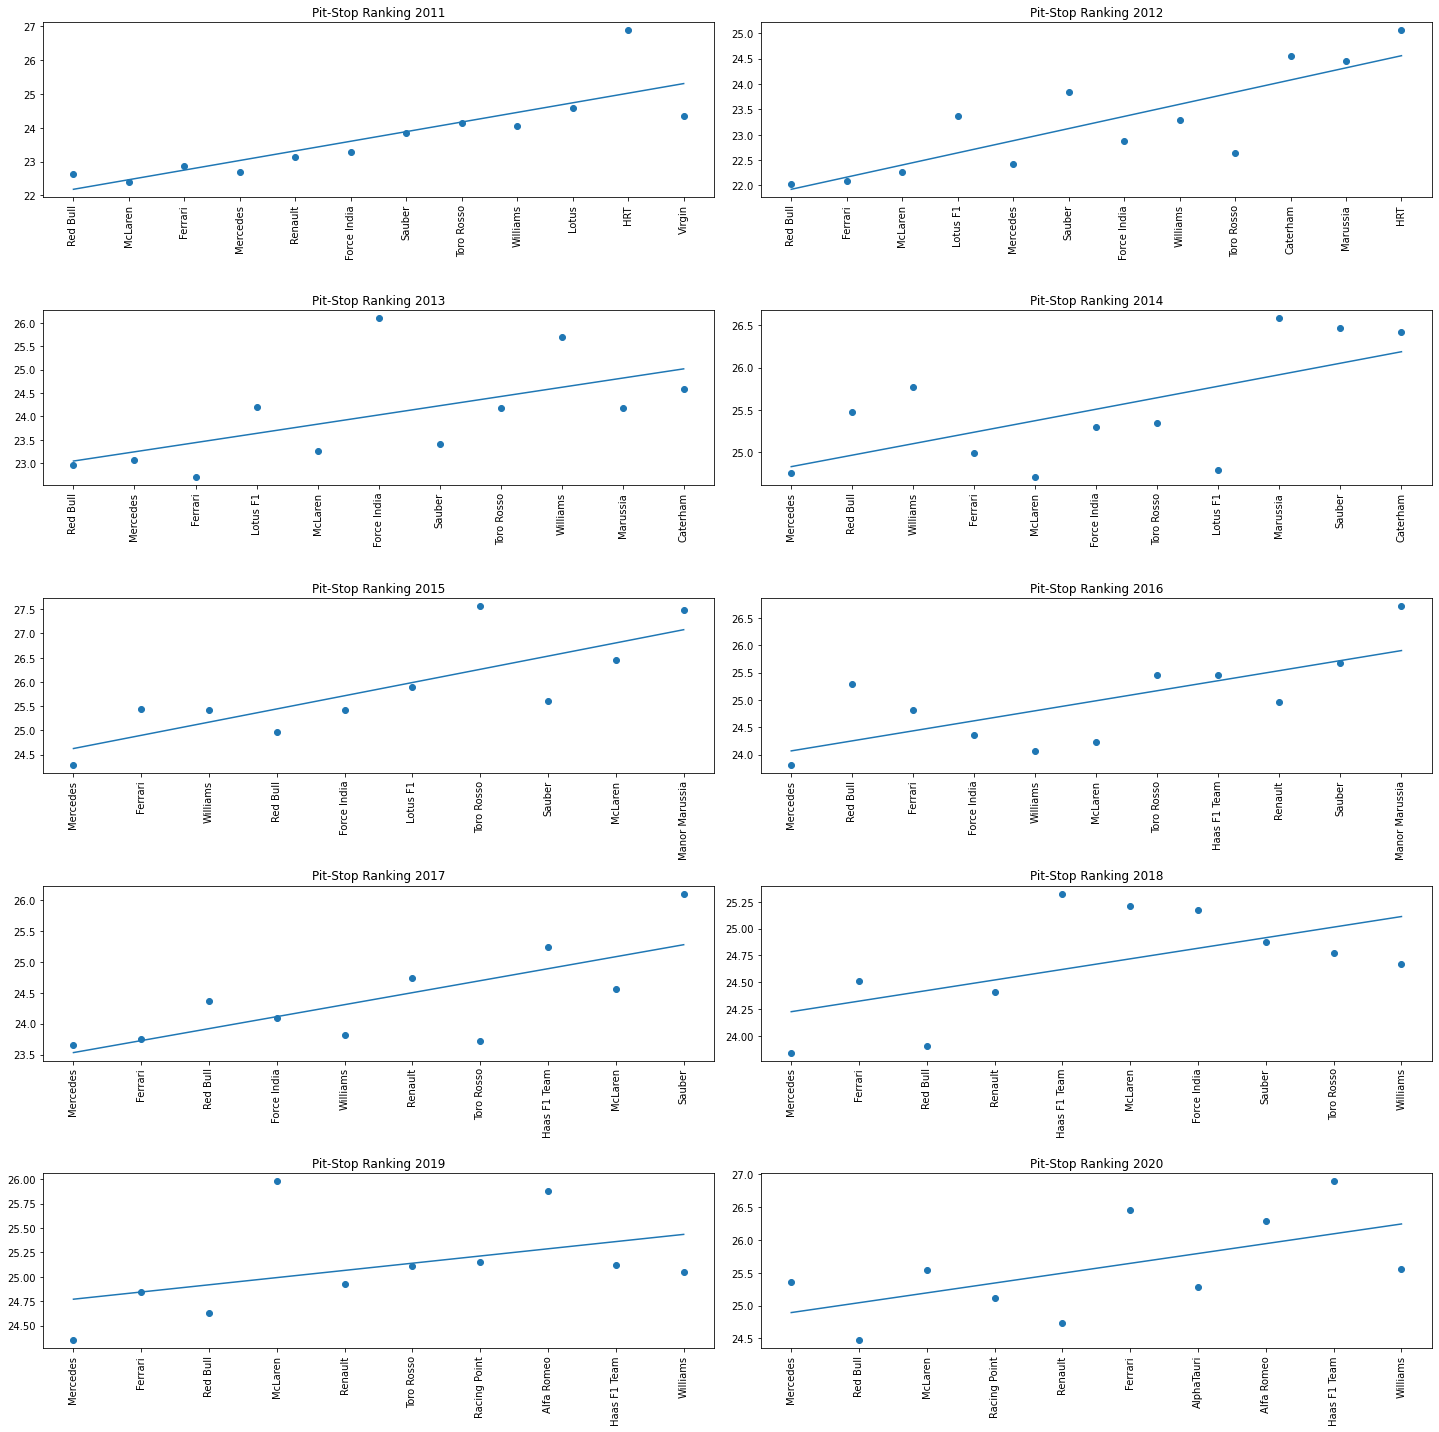

In [84]:
fig, axs = plt.subplots(5,2, figsize=(20, 20))
axs = axs.ravel()
for year in range(2011, 2021):
    x = f1_per_year[year]['constructor_standings']
    y = x[x.raceId == x.raceId.max()][['constructorId', 'position']].values
    c_standings = {naming(v[0],'constructors'):v[1] for v in y}
    c_standings = {v: k for k, v in c_standings.items()}
    xs = np.arange(1, len(c_standings)+1)
    ys = 0.001*np.array([pitstops[year][c_standings[xi]] for xi in xs])
    regr.fit(xs[:,np.newaxis],ys[:,np.newaxis])
    yp = regr.predict(xs[:,np.newaxis])
    print('Coefficients: \n', regr.coef_)
    axs[year-2011].scatter(xs, ys)
    axs[year-2011].plot(xs, yp)
    axs[year-2011].set_xticks(list(c_standings.keys()))
    axs[year-2011].set_xticklabels(list(c_standings.values()), rotation='vertical')
    axs[year-2011].set_title("Pit-Stop Ranking {}".format(year))
plt.tight_layout()
plt.savefig('pitstop_standings_correlation.png')

In [48]:
champs = []
for y in range(2005, 2021):
    ds = f1_per_year[y]['driver_standings']
    dsf = ds[ds.raceId == ds.raceId.max()]
    champs.append(dsf['driverId'][dsf['position'] == 1].values[0])

drivers_2000 = {k:v for (k,v) in drivers_active.items() if len(v) and v[0]>=2000}

In [49]:
races_to_win = {k:0 for k in drivers_2000}
for did in races_to_win:
    for year in drivers_2000[did]:
        for raceId in f1_per_year[year]['results']['raceId'].unique():
            r = f1_per_year[year]['results'][f1_per_year[year]['results']['raceId'] == raceId]
            p = r[r['driverId'] == did]
            if not len(p): continue
            pos = p.values[0][6]
            races_to_win[did] -= 1
            if pos == '1':
                races_to_win[did] = -races_to_win[did]
                break
        if pos == '1': break

In [50]:
for k, v in races_to_win.items():
    if v < 0: print(naming(k,"drivers"), " has no wins.")
    else: print(naming(k,"drivers"), " won his first race after ", v, " tries.")

Lewis Hamilton  won his first race after  6  tries.
Nick Heidfeld  has no wins.
Nico Rosberg  won his first race after  111  tries.
Fernando Alonso  won his first race after  30  tries.
Heikki Kovalainen  won his first race after  28  tries.
Kazuki Nakajima  has no wins.
Sébastien Bourdais  has no wins.
Kimi Räikkönen  won his first race after  36  tries.
Robert Kubica  won his first race after  29  tries.
Timo Glock  has no wins.
Takuma Sato  has no wins.
Nelson Piquet Jr.  has no wins.
Felipe Massa  won his first race after  67  tries.
Adrian Sutil  has no wins.
Mark Webber  won his first race after  132  tries.
Jenson Button  won his first race after  115  tries.
Anthony Davidson  has no wins.
Sebastian Vettel  won his first race after  22  tries.
Vitantonio Liuzzi  has no wins.
Scott Speed  has no wins.
Christijan Albers  has no wins.
Sakon Yamamoto  has no wins.
Juan Pablo Montoya  won his first race after  15  tries.
Christian Klien  has no wins.
Tiago Monteiro  has no wins.
Yuji

In [51]:
races_to_podium = {k:0 for k in drivers_2000}
for did in races_to_podium:
    for year in drivers_2000[did]:
        for raceId in f1_per_year[year]['results']['raceId'].unique():
            r = f1_per_year[year]['results'][f1_per_year[year]['results']['raceId'] == raceId]
            p = r[r['driverId'] == did]
            if not len(p): continue
            pos = p.values[0][6]
            races_to_podium[did] -= 1
            if pos in ['1', '2', '3']:
                races_to_podium[did] = -races_to_podium[did]
                break
        if pos in ['1', '2', '3']: break

In [52]:
for k, v in races_to_podium.items():
    if v < 0: print(naming(k,"drivers"), "has no podiums.")
    else: print(naming(k,"drivers"), "score his first podium after", v, "tries.")

Lewis Hamilton score his first podium after 1 tries.
Nick Heidfeld score his first podium after 19 tries.
Nico Rosberg score his first podium after 36 tries.
Fernando Alonso score his first podium after 19 tries.
Heikki Kovalainen score his first podium after 15 tries.
Kazuki Nakajima has no podiums.
Sébastien Bourdais has no podiums.
Kimi Räikkönen score his first podium after 18 tries.
Robert Kubica score his first podium after 3 tries.
Timo Glock score his first podium after 15 tries.
Takuma Sato score his first podium after 27 tries.
Nelson Piquet Jr. score his first podium after 10 tries.
Felipe Massa score his first podium after 58 tries.
Adrian Sutil has no podiums.
Mark Webber score his first podium after 57 tries.
Jenson Button score his first podium after 69 tries.
Anthony Davidson has no podiums.
Sebastian Vettel score his first podium after 22 tries.
Vitantonio Liuzzi has no podiums.
Scott Speed has no podiums.
Christijan Albers has no podiums.
Sakon Yamamoto has no podiums

In [53]:
races_to_pole = {k:0 for k in drivers_2000}
for did in races_to_pole:
    for year in drivers_2000[did]:
        for raceId in f1_per_year[year]['qualifying']['raceId'].unique():
            r = f1_per_year[year]['qualifying'][f1_per_year[year]['qualifying']['raceId'] == raceId]
            p = r[r['driverId'] == did]
            if not len(p): continue
            pos = p.values[0][5]
            races_to_pole[did] -= 1
            if pos == 1:
                races_to_pole[did] = -races_to_pole[did]
                break
        if pos == 1: break

In [54]:
for k, v in races_to_pole.items():
    if v < 0: print(naming(k,"drivers"), "has no poles.")
    else: print(naming(k,"drivers"), "score his first pole after", v, "tries.")

Lewis Hamilton score his first pole after 6 tries.
Nick Heidfeld score his first pole after 42 tries.
Nico Rosberg score his first pole after 111 tries.
Fernando Alonso score his first pole after 2 tries.
Heikki Kovalainen score his first pole after 26 tries.
Kazuki Nakajima has no poles.
Sébastien Bourdais has no poles.
Kimi Räikkönen score his first pole after 12 tries.
Robert Kubica score his first pole after 25 tries.
Timo Glock has no poles.
Takuma Sato has no poles.
Nelson Piquet Jr. has no poles.
Felipe Massa score his first pole after 53 tries.
Adrian Sutil has no poles.
Mark Webber score his first pole after 117 tries.
Jenson Button score his first pole after 28 tries.
Anthony Davidson has no poles.
Sebastian Vettel score his first pole after 22 tries.
Vitantonio Liuzzi has no poles.
Scott Speed has no poles.
Christijan Albers has no poles.
Sakon Yamamoto has no poles.
Juan Pablo Montoya score his first pole after 15 tries.
Christian Klien has no poles.
Tiago Monteiro has no p

In [55]:
df = pd.DataFrame(
    {'to_win':races_to_win.values(),
     'to_podium':races_to_podium.values(),
     'to_pole':races_to_pole.values(),
     'champion': [1 if d in champs else 0 for d in drivers_2000]
    }, index = [naming(d,'drivers') for d in drivers_2000])
df[df<0] = -1
df[df.champion == 1]

,to_win,to_podium,to_pole,champion
Lewis Hamilton,6,1,6,1
Nico Rosberg,111,36,111,1
Fernando Alonso,30,19,2,1
Kimi Räikkönen,36,18,12,1
Jenson Button,115,69,28,1
Sebastian Vettel,22,22,22,1


In [56]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()

predictors = pd.DataFrame([df['to_win'], df['to_podium'], df['to_pole']]).T
tree_model.fit(X = predictors, y = df['champion'])

DecisionTreeClassifier()

In [57]:
with open("mytree.dot", 'w') as f:
     f = tree.export_graphviz(tree_model, 
                              feature_names=["Win", "Podium", "Pole"], 
                              out_file=f)

In [59]:
#!dot -Tpng mytree.dot -o mytree.png -Gdpi=100
# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'mytree.png')

In [99]:
print(teams[2016][9])

([-3, 1, -4, -6, -5, -6, -13, -13, -12, -7, -13, -7, -8, -15, -5], [-10, -4, -2, -10, -9, -11, -9, -16, -14, -5, -11, -7, -10, -14, -8])


In [98]:
naming(9, 'constructors')

'Red Bull'